# Fitting NorESM2 with ice mods

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
files = os.listdir(case_dir)
files.sort()
files

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

In [6]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

mainmetric = CT_SLF_Metric(case_dir)
mainmetric.add_case(origin_case) # origin point
mainmetric.add_case('20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01')
mainmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05')
#mainmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.3_inp_0.01')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_1.0')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_1.0_inp_0.1')
mainmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

mainmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_1.0_inp_0.1
Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


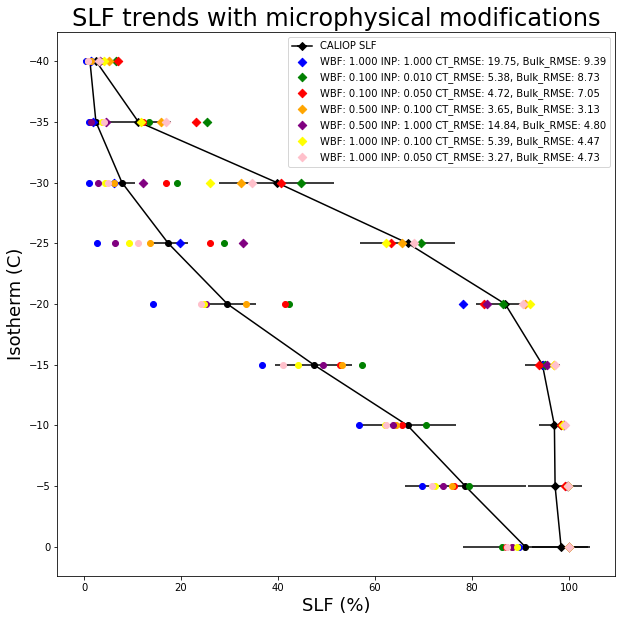

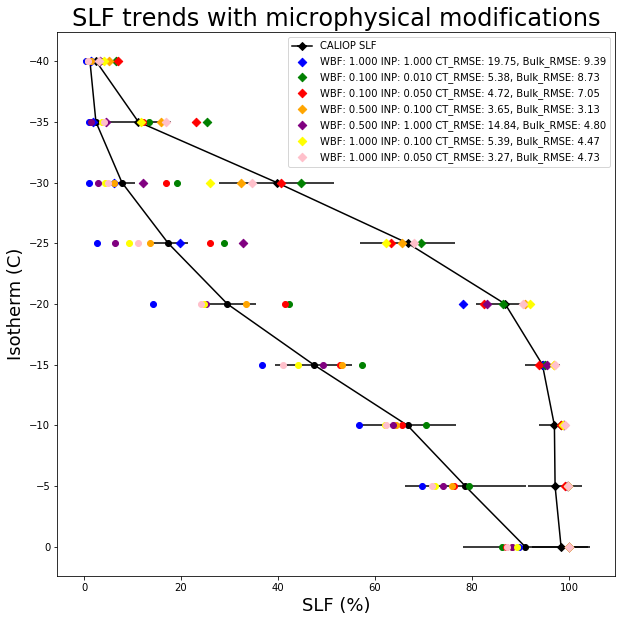

In [7]:
mainmetric.plot_isos_all()

In [4]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

testmetric = CT_SLF_Metric(case_dir)
testmetric.add_case(origin_case) # origin point
testmetric.add_case('20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01')
testmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05')
testmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')
testmetric.add_case('20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_0.2')
testmetric.add_case('20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_1.0')
testmetric.add_case('20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3')


testmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_0.2


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


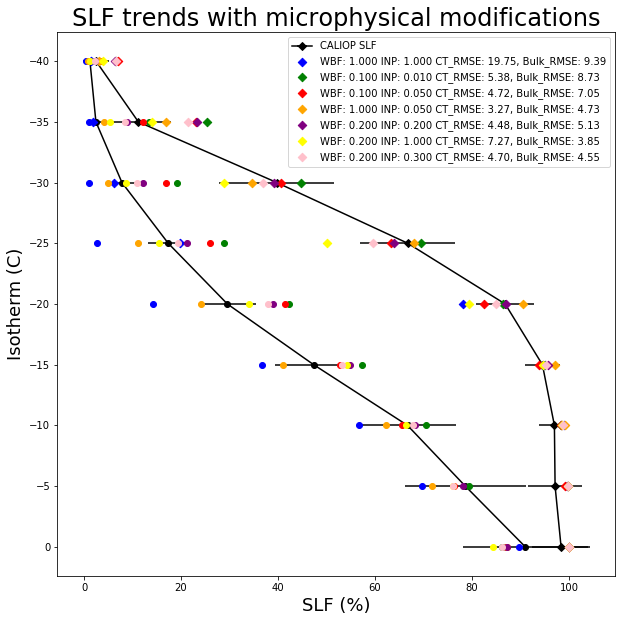

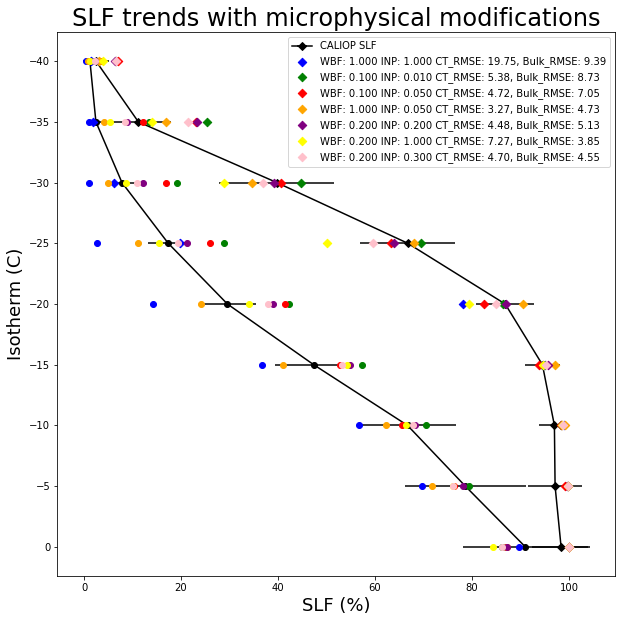

In [5]:
testmetric.plot_isos_all()

-7.7830673996041675 -10.393336664941275
6.4769404630783685 3.4912063811528555
4.346775641635598 1.4949273695262073
-3.864309140918097 1.6910276696673803
3.2971047999205263 2.167761476126698
0.4363558089088087 -2.784347376552808
2.2480534890533836 1.0313430437876532


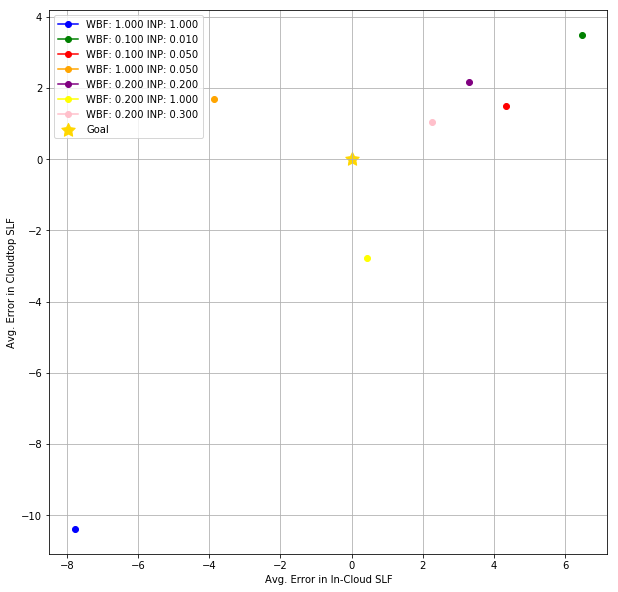

In [6]:
testmetric.dual_parameterspace()

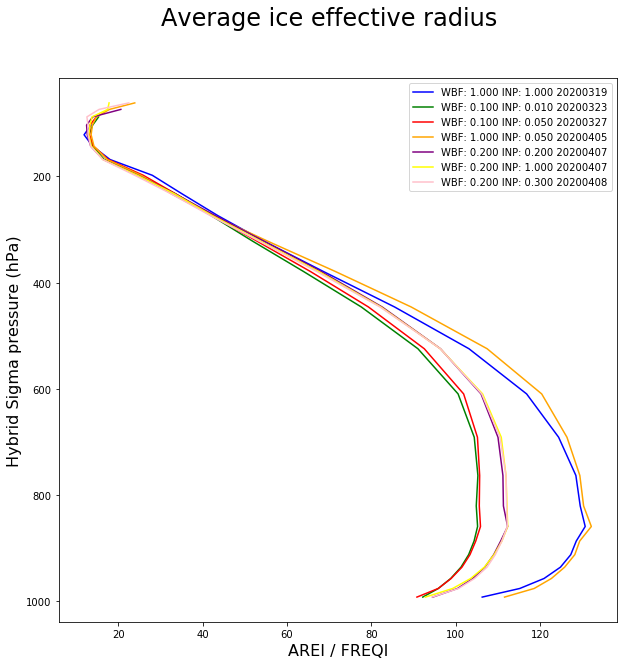

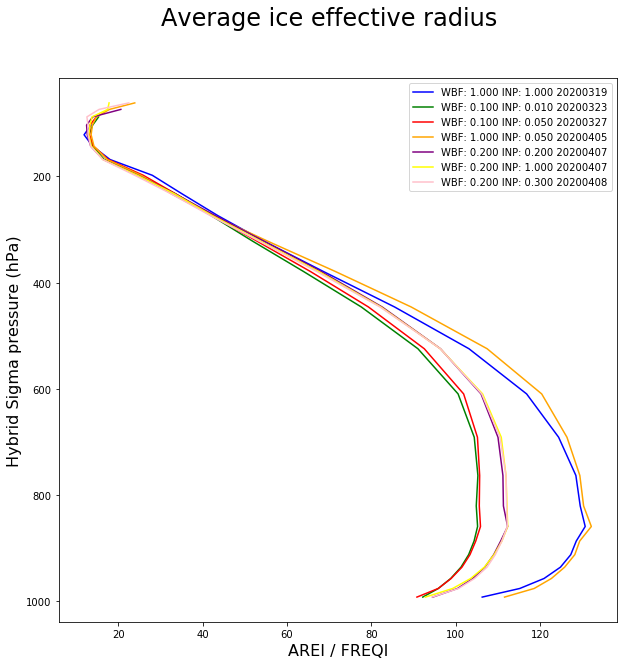

In [7]:
testmetric.plot_var_ratio('AREI','FREQI')

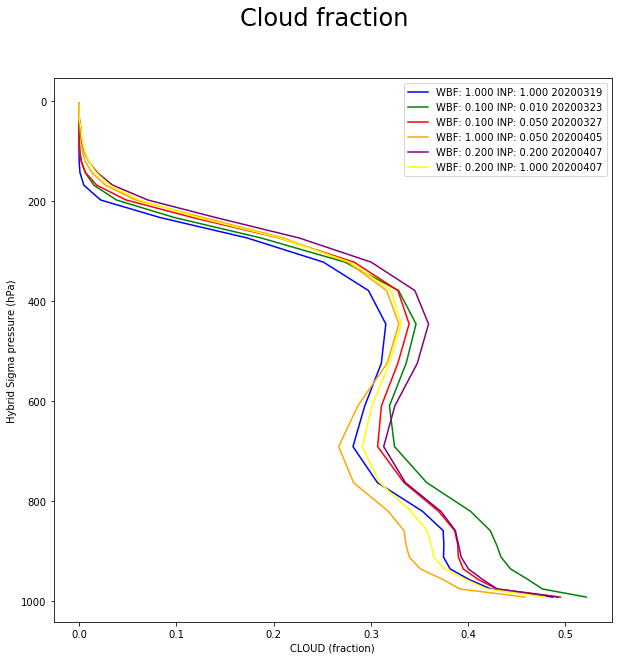

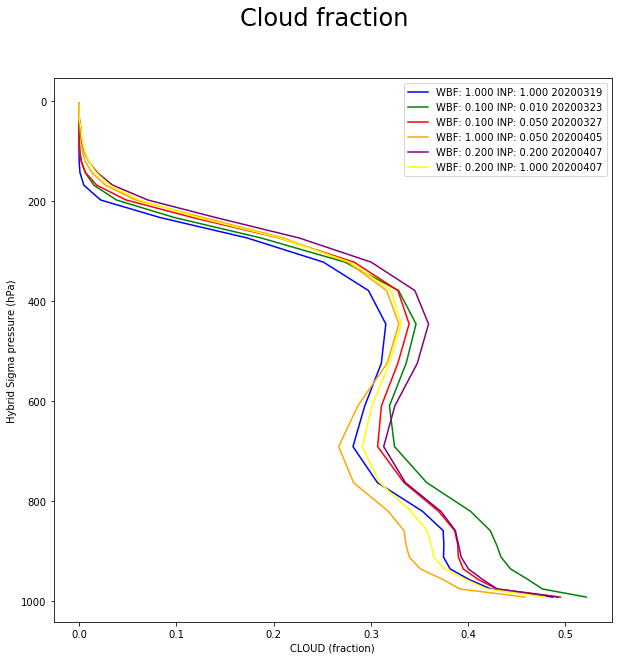

In [8]:
testmetric.plot_single_var('CLOUD')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


-7.7830673996041675 -10.393336664941275
6.4769404630783685 3.4912063811528555
4.346775641635598 1.4949273695262073
4.679587339684023 8.214468434256624
-0.2103374384133024 1.2676664468774552
-3.364598691653228 -7.119227524213057
-3.529575353608191 -0.27972535434838897


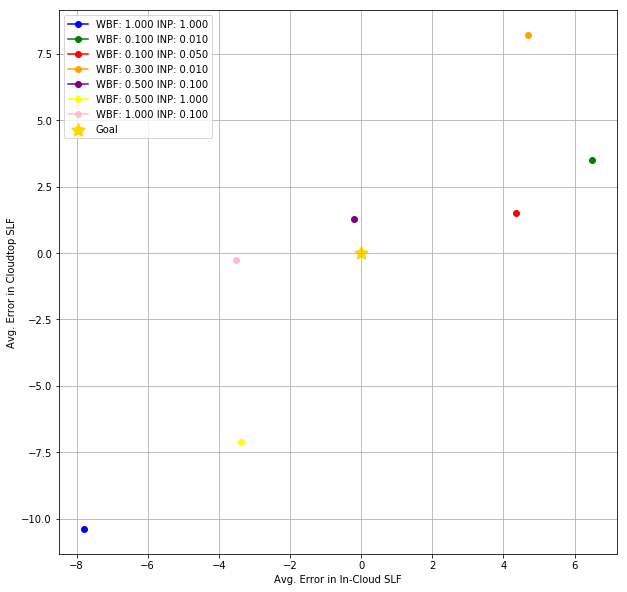

In [6]:
mainmetric.dual_parameterspace()

In [8]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

bestmetric = CT_SLF_Metric(case_dir)
bestmetric.add_case(origin_case) # origin point
bestmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1')
bestmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

bestmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1
Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


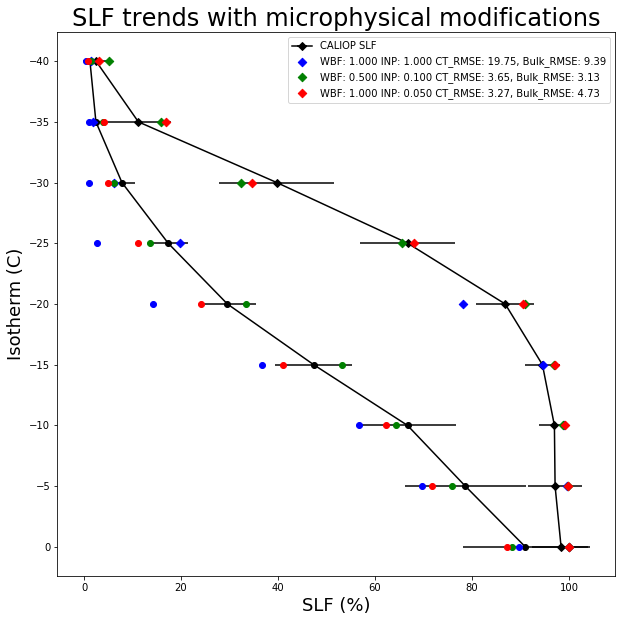

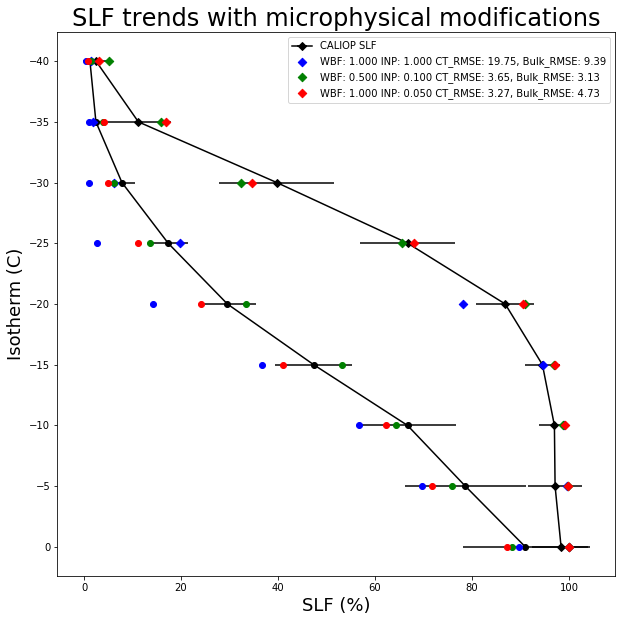

In [10]:
bestmetric.plot_isos_all()

-7.7830673996041675 -10.393336664941275
-0.2103374384133024 1.2676664468774552
-3.864309140918097 1.6910276696673803


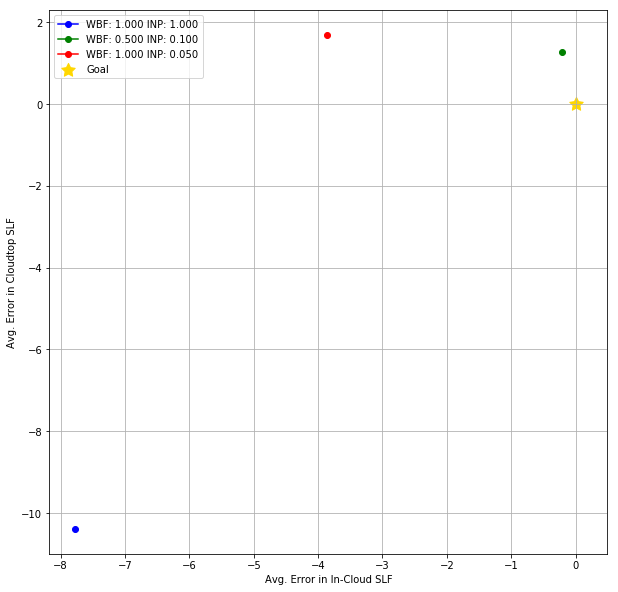

In [9]:
bestmetric.dual_parameterspace()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


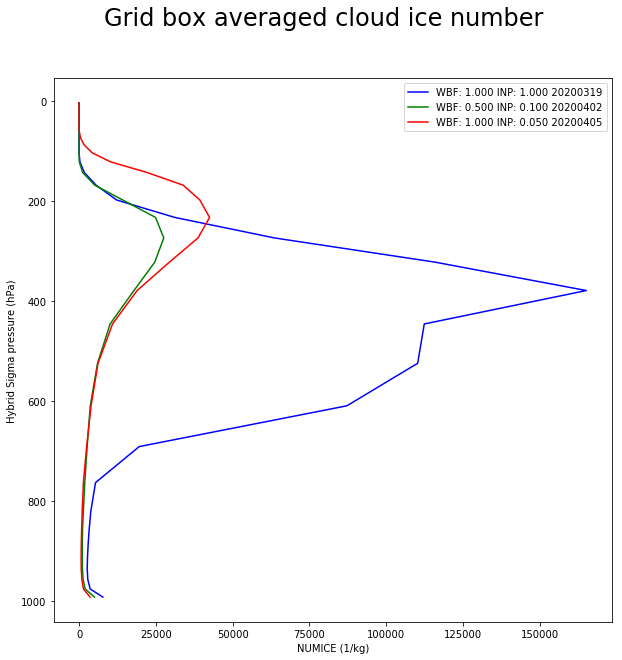

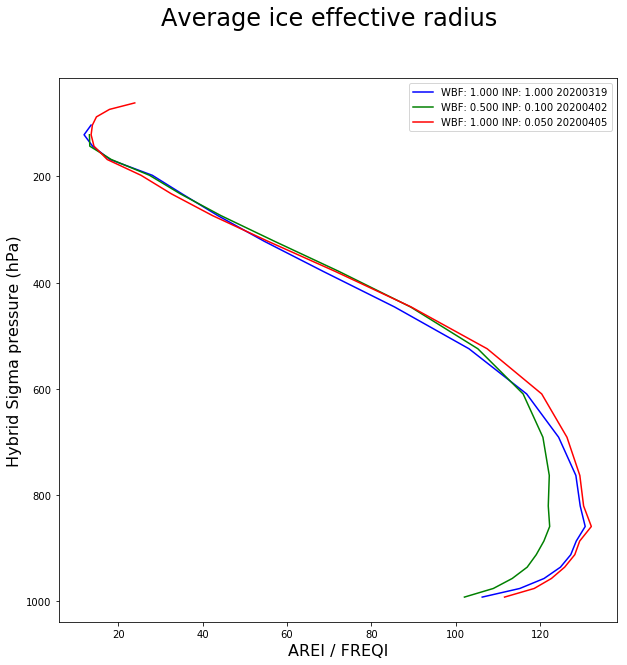

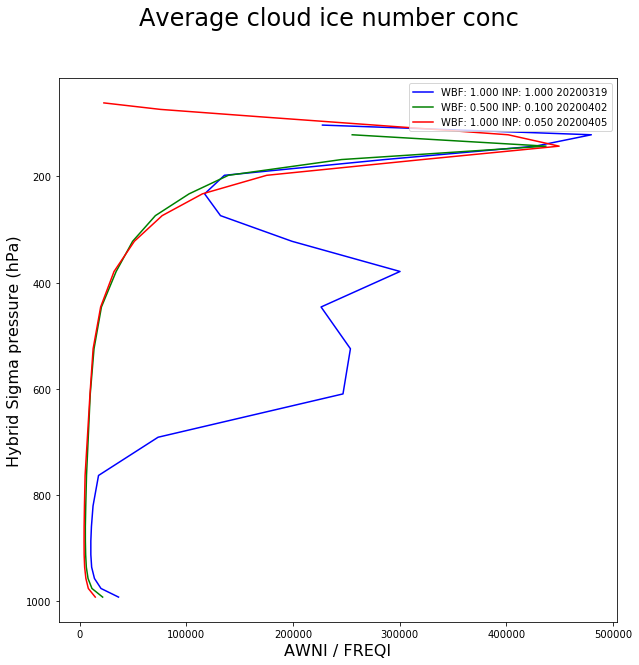

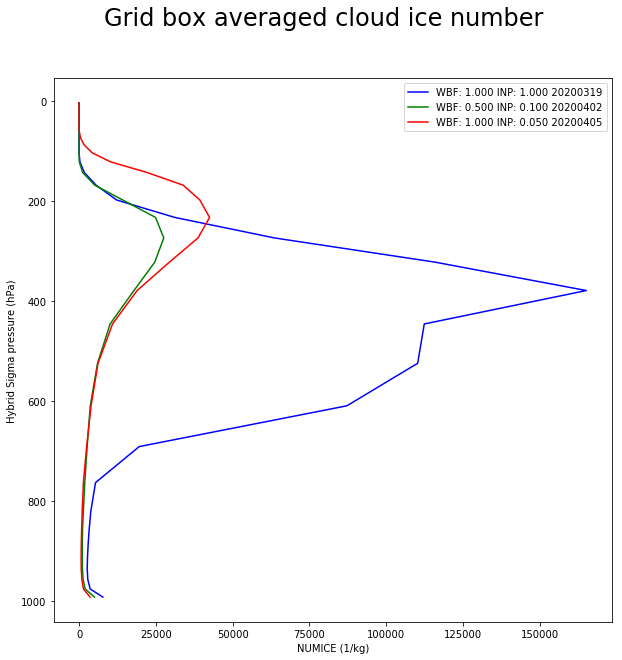

In [11]:
bestmetric.plot_var_ratio('AREI','FREQI')
bestmetric.plot_var_ratio('AWNI','FREQI')
bestmetric.plot_single_var('NUMICE')

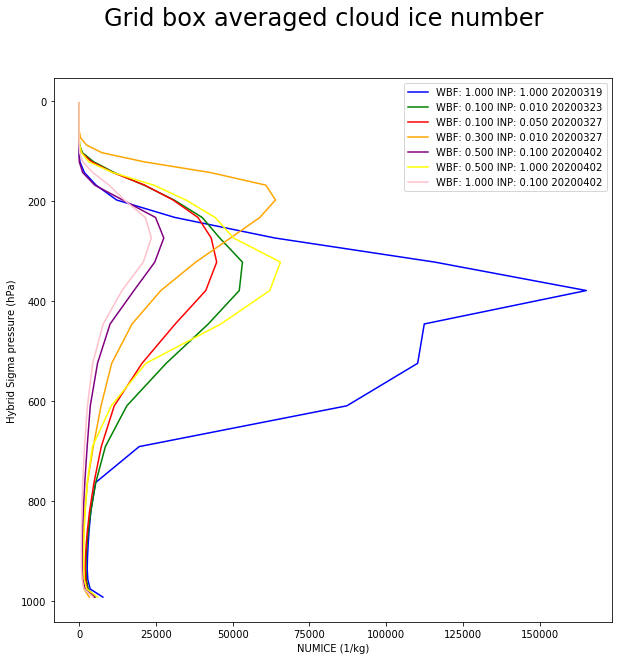

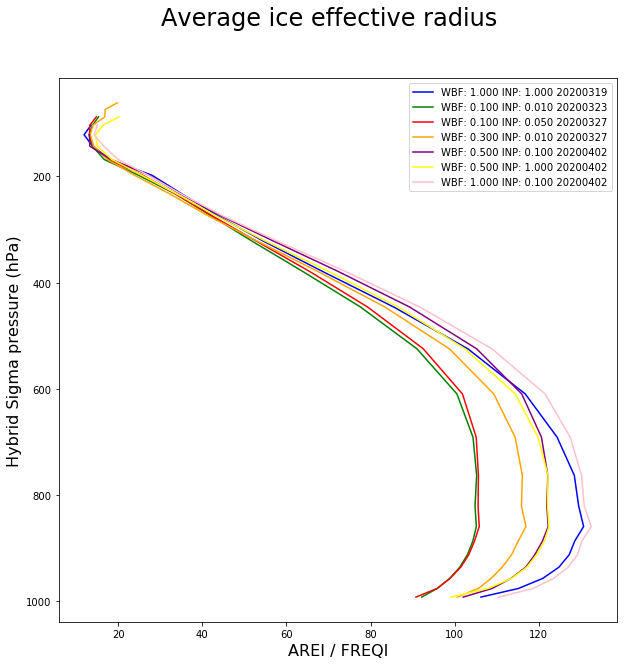

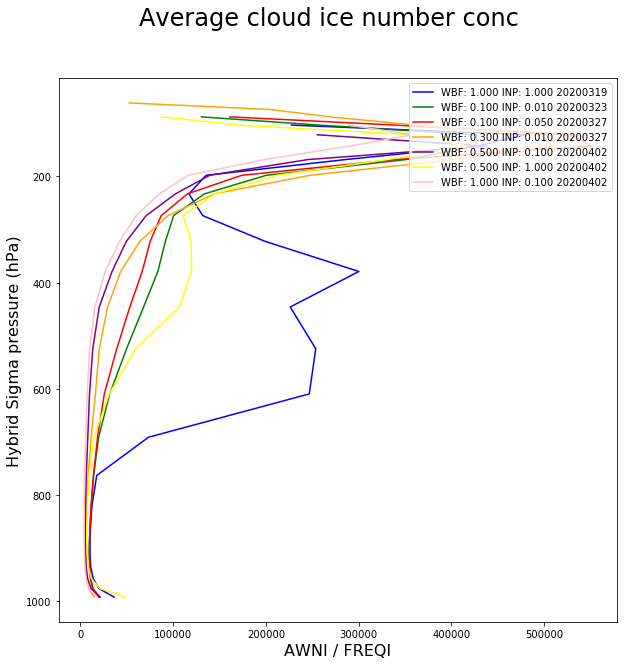

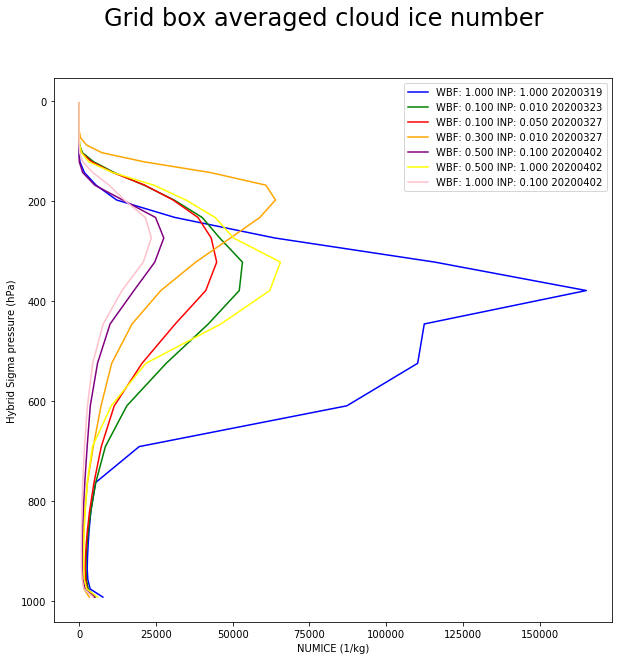

In [9]:
mainmetric.plot_var_ratio('AREI','FREQI')
mainmetric.plot_var_ratio('AWNI','FREQI')
mainmetric.plot_single_var('NUMICE')